In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

# Wrangling and Transforming

We begin by taking a peek at the contents of our data file.
To do this, we open the file and examine the first few rows
({numref}`Chapter %s <ch:files>`).

In [2]:
from pathlib import Path

# Create a Path pointing to our data file
insp_path = Path() / 'data' / 'donkeys.csv'

with insp_path.open() as f:
    # Display first five lines of file
    for _ in range(5):
        print(f.readline(), end='')

BCS,Age,Sex,Length,Girth,Height,Weight,WeightAlt
3,<2,stallion,78,90,90,77,NA
2.5,<2,stallion,91,97,94,100,NA
1.5,<2,stallion,74,93,95,74,NA
3,<2,female,87,109,96,116,NA


Since the file is CSV formatted, we can easily read it into a dataframe.

In [17]:
donkeys = pd.read_csv("donkeys.csv")
donkeys

,BCS,Age,Sex,Length,Girth,Height,Weight,WeightAlt
0,3.0,<2,stallion,78,90,90,77,NaN
1,2.5,<2,stallion,91,97,94,100,NaN
2,1.5,<2,stallion,74,93,95,74,NaN
...,...,...,...,...,...,...,...,...
541,2.5,10-15,stallion,103,118,103,174,NaN
542,3.0,2-5,stallion,91,112,100,139,NaN
543,3.0,5-10,stallion,104,124,110,189,NaN


Over 500 donkeys participated in the survey, and eight measurements were make on each donkey. According to the documentation, the granularity is a single donkey ({numref}`Chapter %s <ch:wrangling>`).
{numref}`Table %s <tbl:donkey-codebook>` below provides descriptions of the eight features.

:::{table} Donkey Study Codebook
:name: tbl:donkey-codebook

| Feature        | Data Type | Feature Type      | Description                                                        |
|----------------|-----------|------------|--------------------------------------------------------|
|BCS    | float64 |  ordinal | Body Condition Score: from 1 (emaciated) through 3 (healthy) to 5 (obese) in increments of 0.5. |
| Age          | string |  ordinal | Age in years, under 2, 2-5, 5-10, 10-15, 15-20, and over 20 years. |
| Sex          | string | nominal | Sex categories: stallion, gelding, female.  |
| Length      | int64 | numeric | body length (cm) from front leg elbow to back of pelvis. |
| Girth       | int64 | numeric | body circumference (cm), measured just behind front legs. |
| Height | int64 | numeric | body height (cm) up to point where neck connects to back.     |
| Weight    |int64   | numeric | weight (kilogram).   |
| WeightAlt  |float64  | numeric | second weight measurement taken on a small subset of donkeys.  |

:::



{numref}`Figure %s <fig:donkeyDiagram>` is a stylized representation of a donkey as a cylinder with neck and legs appended. Notice the height measurement includes the legs. The girth and length are the circumference and length of the cylinder. 

```{figure} donkeyDiagram.png
---
name: fig:donkeyDiagram
---
The cylinder shown here represents the body of a donkey. Girth is measured around the body just behind the front legs, height is measured from the ground to where the neck connects to the top of the back, and length is measured from the front elbow to the back of the pelvis. 
```

Our next step is to perform some quality checks on the data. In the previous section, we listed a few potential quality concerns based on scope. Next, we check the quality of the measurements and their distributions.

Let's start with comparing the two weight measurements to check on the consistency of the scale. Below is a histogram of the difference between these two measurements for the small subset of donkeys that were weighed twice. 

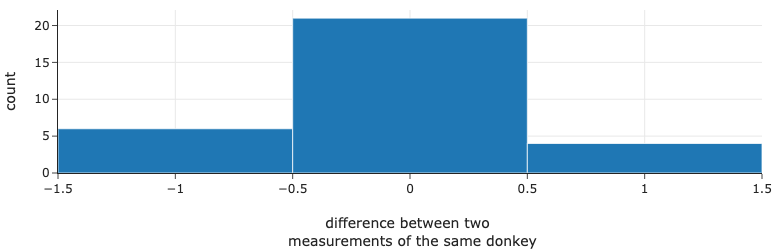

In [26]:
donkeys['difference'] = donkeys['WeightAlt'] - donkeys['Weight']

fig = px.histogram(donkeys, x='difference', nbins=3,
                   width=350, height=250)
fig.update_xaxes(title='difference between two <br> measurements of the same donkey')
fig

The measurements are all within 1 kg of each other, and the majority are exactly the same (to the nearest kilogram).

Next, we look for unusual values in the body condition score. 

In [27]:
donkeys['BCS'].value_counts()

3.0    307
2.5    135
3.5     55
      ... 
1.5      5
4.5      1
1.0      1
Name: BCS, Length: 8, dtype: int64

From this output, we see that there's only one donkey with a body condition score of 1 (emaciated) and one donkey with a score of 4.5 (obese).
Let's look at these two donkeys.

In [28]:
donkeys[(donkeys['BCS'] == 1.0) | (donkeys['BCS'] == 4.5)]

,BCS,Age,Sex,Length,...,Height,Weight,WeightAlt,difference
291,4.5,10-15,female,107,...,106,227,NaN,NaN
445,1.0,>20,female,97,...,102,115,NaN,NaN


Since these BCS values also have outlier weights,
we'll remove these two records. We may also decide to remove the five donkeys with a score of 1.5, if they appear anomalous in our later analysis. 

In [29]:
def remove_bcs_outliers(donkeys):
    return donkeys[(donkeys['BCS'] >= 1.5) & (donkeys['BCS'] <= 4)] 

donkeys = (pd.read_csv('data/donkeys.csv')
           .pipe(remove_bcs_outliers))

Next, we examine the distribution of values for weight to see if there are any issues with quality. 

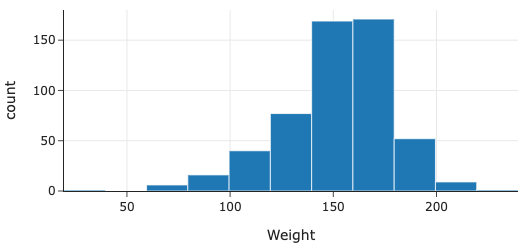

In [30]:
fig = px.histogram(donkeys, x='Weight', nbins=20,
                   width=350, height=250)
fig

Next, we'll check the relationship between weight and height to assess the quality of the data for analysis.

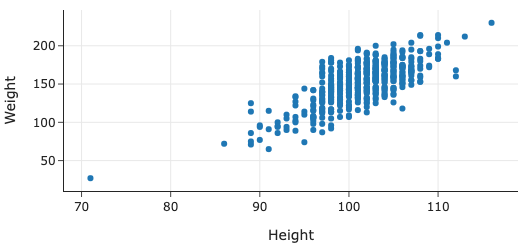

In [34]:
fig = px.scatter(donkeys, x='Height', y='Weight',
                 width=350, height=250)
fig

It appears that there is one very light donkey.
The small donkey is far from the main concentration of donkeys and would overly influence our models. For this reason, we exclude it. Again, we keep in mind that we may also want to exclude the one or two heavy donkeys, if they appear to overly influence our future model fitting. 

In [36]:
def remove_weight_outliers(donkeys):
    return donkeys[(donkeys['Weight'] >= 40)]

donkeys = (pd.read_csv('data/donkeys.csv')
           .pipe(remove_bcs_outliers)
           .pipe(remove_weight_outliers))

donkeys.shape

(541, 8)

In summary, based on our cleaning and quality checks, we removed three anomalous observations from the data frame. Now, we're nearly ready to begin our exploratory analysis.
Before we proceed, we'll set aside some of our data as a test set.

# Train-Test Split of the Data

We talked about why it's important to separate out a test set from the training set in {numref}`Chapter %s <ch:linear>`.
When our goal is to create a model, we consider it best practice to separate out a test set early in the analysis, before we explore the data in detail.
When we explore a dataset, we implicitly make 
decisions about what kinds of models to fit and what variables to use in the model.
It's important that our test set isn't involved in these decisions so that it simulates completely new data to evaluate our model.

We'll divide our data into an 80/20 split, where we use 80\% of the data to explore and build a model. Then, we evaluate the model with the 20\% that has been set aside. 

In [37]:
np.random.seed(42)
n = len(donkeys)
indices = np.arange(n)
np.random.shuffle(indices)
n_train = int(np.round((0.8 * n)))

The code above takes a random shuffle of the indices for the data frame.
Next, we assign the first 80\% to the training data frame and the remaining 20% to the test set.   

In [42]:
train_set = donkeys.iloc[indices[:n_train]]
test_set = donkeys.iloc[indices[n_train:]]

We confirm that the test and train sets are the expected shape.

In [43]:
train_set.shape

(433, 8)

In [44]:
test_set.shape

(108, 8)

Next, we'll explore the training data to look for useful relationships and distributions that inform our modeling. 